In [77]:
borrower_df = pd.read_csv(r"C:\Users\jack\OneDrive\AU2024\jobs\KeyBank\borrower.csv")
loans_df = pd.read_csv(r"C:\Users\jack\OneDrive\AU2024\jobs\KeyBank\loans.csv")
merged_df = pd.merge(borrower_df, loans_df, on='Account_Number', how='inner')

merged_df.head(50)

merged_df.drop(['Country_Code', 'Income_Annual', 'Collateral_Value', 'Payment_Amount', 'Num_Trades_Past_Due', 'Num_HE_Trades'],  axis=1, inplace = True)
merged_df.fillna(0, inplace=True)
merged_df['Account_Number'] = merged_df['Account_Number'].astype(str)
merged_df['Zip_Code'] = merged_df['Zip_Code'].astype(str)

merged_df['FICO_Score_Original'] = merged_df.apply(
    lambda row: row['FICO_Score_Current'] if row['FICO_Score_Original'] == 0 and row['FICO_Score_Current'] != 0 else row['FICO_Score_Original'],
    axis=1
)

merged_df['FICO_Score_Current'] = merged_df.apply(
    lambda row: row['FICO_Score_Original'] if row['FICO_Score_Current'] == 0 and row['FICO_Score_Original'] != 0 else row['FICO_Score_Current'],
    axis=1
)

In [78]:
# Summary statistics for numerical fields
summary_stats = merged_df.describe()
print(summary_stats)

       Total_Mortgage_Balances  Total_HE_Balances  FICO_Score_Original  \
count             2.997000e+04       2.997000e+04         29970.000000   
mean              1.592274e+04       3.057457e+04           678.313280   
std               6.946596e+04       6.110413e+04           214.245297   
min               0.000000e+00       0.000000e+00             0.000000   
25%               0.000000e+00       0.000000e+00           671.000000   
50%               0.000000e+00       0.000000e+00           735.000000   
75%               0.000000e+00       4.215400e+04           790.000000   
max               1.748134e+06       1.510888e+06           893.000000   

       FICO_Score_Current   Commitments  Outstandings  LTV_Original  \
count        29970.000000  2.997000e+04  2.997000e+04  29970.000000   
mean           664.964665  3.392026e+04  3.385923e+04      0.435071   
std            214.436863  4.281034e+04  4.294814e+04      0.309603   
min              0.000000  0.000000e+00 -7.169974

In [79]:
columns_of_interest = ['FICO_Score_Current', 'Total_HE_Balances', 'Origination_DTI', 'Day_Past_Due', 'LTV_Current']
relevant_data = merged_df[columns_of_interest]
relevant_data.describe()

,FICO_Score_Current,Total_HE_Balances,Origination_DTI,Day_Past_Due,LTV_Current
count,29970.000000,2.997000e+04,29970.000000,29970.000000,29970.000000
mean,664.964665,3.057457e+04,0.245344,48.708108,0.261772
std,214.436863,6.110413e+04,0.630409,347.690019,0.322907
min,0.000000,0.000000e+00,0.000000,0.000000,-0.267000
25%,646.000000,0.000000e+00,0.000000,0.000000,0.016000
50%,723.000000,0.000000e+00,0.221000,0.000000,0.149000
75%,783.000000,4.215400e+04,0.368000,0.000000,0.411000
max,1049.000000,1.510888e+06,10.499000,8556.000000,6.530000


In [80]:
from sklearn.model_selection import train_test_split

merged_df['Delinquent'] = merged_df['Day_Past_Due'] > 0

X = relevant_data.drop('Day_Past_Due', axis=1)
y = merged_df['Delinquent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [81]:
from sklearn.ensemble import RandomForestClassifier

# Train a random forest model with class weighting
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

       False       0.95      0.94      0.94      8047
        True       0.52      0.57      0.55       944

    accuracy                           0.90      8991
   macro avg       0.74      0.75      0.75      8991
weighted avg       0.90      0.90      0.90      8991



In [82]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix)

[[7558  489]
 [ 406  538]]


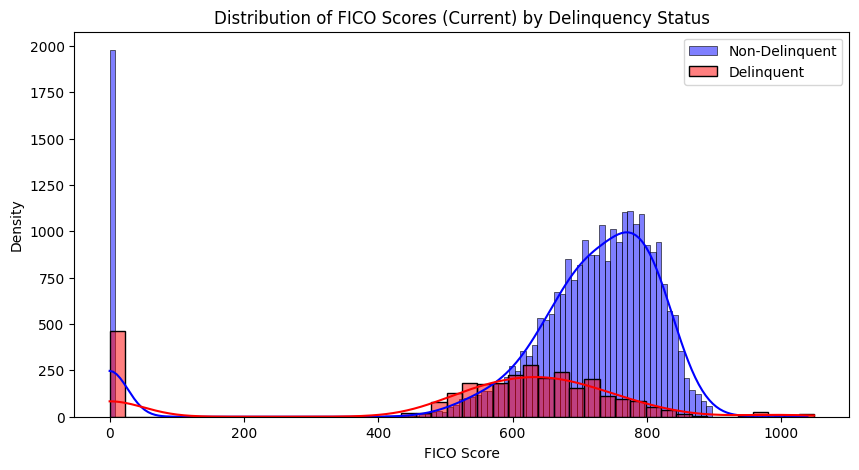

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

df = merged_df

plt.figure(figsize=(10,5))
sns.histplot(df[df['Delinquent'] == 0]['FICO_Score_Current'], color='blue', label='Non-Delinquent', kde=True)
sns.histplot(df[df['Delinquent'] == 1]['FICO_Score_Current'], color='red', label='Delinquent', kde=True)
plt.title('Distribution of FICO Scores (Current) by Delinquency Status')
plt.xlabel('FICO Score')
plt.ylabel('Density')
plt.legend()
plt.show()

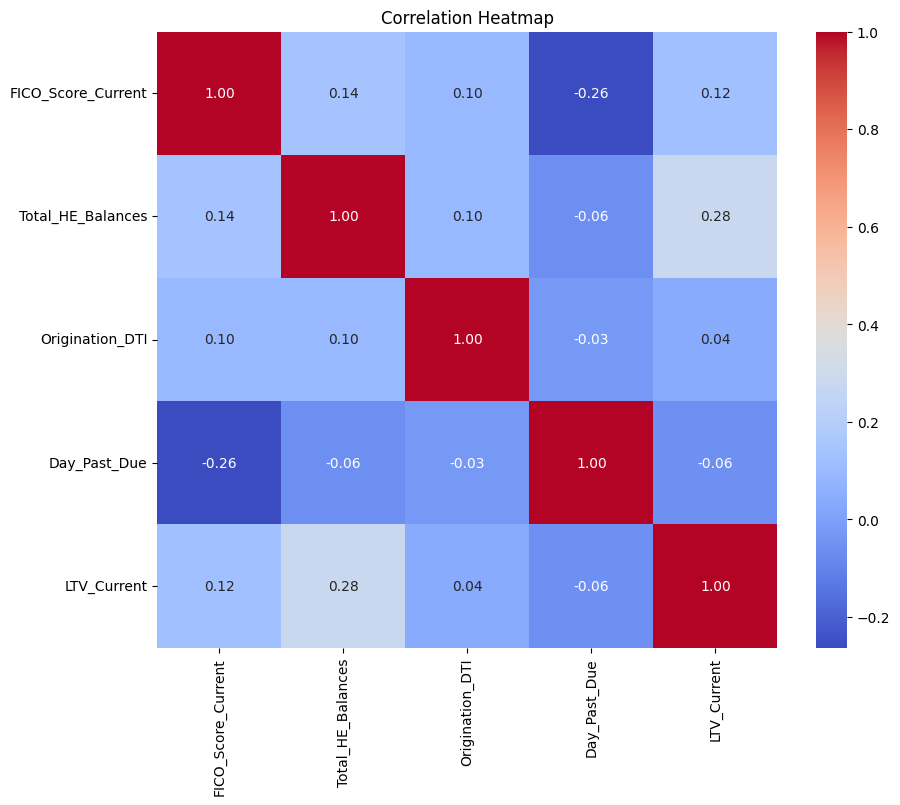

In [84]:
# Compute the correlation matrix
corr_matrix = relevant_data.corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

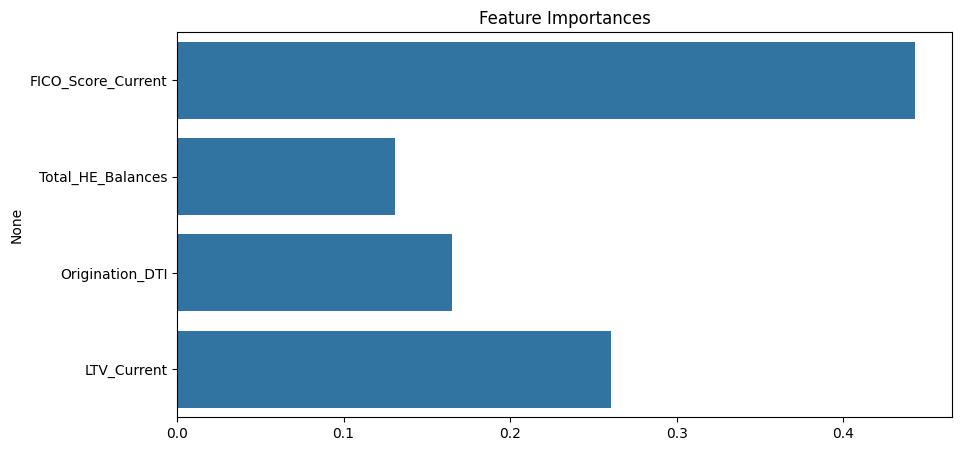

In [85]:
# For tree-based models like RandomForestClassifier
importances = rf_model.feature_importances_
features = X.columns

# Create a bar plot of feature importances
plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.show()


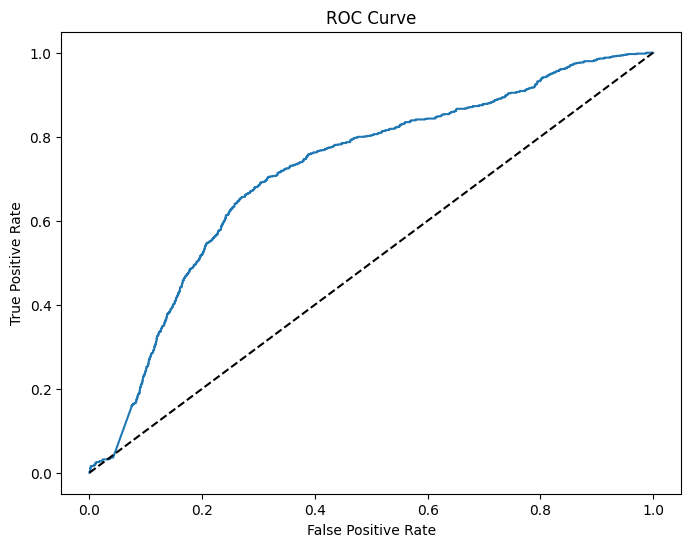

In [86]:
from sklearn.metrics import roc_curve

# Get predicted probabilities from the model
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()